# CodeCarbon Example: Measuring CO2 Emissions

This notebook demonstrates how to use CodeCarbon to track CO2 emissions while training a machine learning model.

In [2]:
# Install required packages if not already installed
!pip install codecarbon scikit-learn pandas numpy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from codecarbon import EmissionsTracker
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import time

In [2]:
from codecarbon import EmissionsTracker  # Changed back to regular EmissionsTracker
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import time
import os
import glob

def cleanup_tracker():
    """Clean up all CodeCarbon related files"""
    try:
        # Remove lock files
        lock_files = glob.glob("/var/folders/*/.codecarbon.lock") + ["./.codecarbon.lock"]
        for lock_file in lock_files:
            if os.path.exists(lock_file):
                os.remove(lock_file)
                
        # Remove other CodeCarbon files
        if os.path.exists("./.carbonboard"):
            os.remove("./.carbonboard")
        if os.path.exists("./.codecarbon.pid"):
            os.remove("./.codecarbon.pid")
            
        # Remove temp lock files
        temp_locks = glob.glob("/tmp/.codecarbon.lock")
        for lock in temp_locks:
            if os.path.exists(lock):
                os.remove(lock)
    except Exception as e:
        print(f"Cleanup error: {e}")

# Ensure emissions directory exists
os.makedirs('emissions', exist_ok=True)

# Clean up before starting
cleanup_tracker()

# Generate dataset
print("Generating dataset...")
X, y = make_classification(
    n_samples=100000,
    n_features=50,
    n_informative=40,
    n_redundant=10,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def train_model_with_emissions():
    cleanup_tracker()
    
    tracker = EmissionsTracker(
        project_name="random_forest_example",
        output_dir="emissions",
        log_level="warning",
        measure_power_secs=15,
        save_to_file=True,
        allow_multiple_runs=True  # Allow multiple runs
    )
    
    try:
        print("Starting emission tracking...")
        tracker.start()

        rf_model = RandomForestClassifier(
            n_estimators=1000,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            n_jobs=-1,
            random_state=42
        )

        start_time = time.time()
        
        print("Training model...")
        rf_model.fit(X_train, y_train)
        
        print("Making predictions...")
        rf_model.predict(X_test)
        
        duration = time.time() - start_time
        print(f"Computation took {duration:.2f} seconds")

        # Explicitly stop the tracker
        emissions = tracker.stop()
        
        return emissions, rf_model
        
    except Exception as e:
        print(f"An error occurred: {e}")
        if tracker:
            tracker.stop()
        return None, None
    finally:
        cleanup_tracker()

# Run the training
print("Starting main computation...")
emissions, model = train_model_with_emissions()

if emissions is not None:
    print(f"\nTotal emissions: {emissions:.4f} kg CO2eq")
else:
    print("\nNo emissions data recorded")

# Try to read and display the emissions file
try:
    # List all CSV files in emissions directory
    emission_files = glob.glob('emissions/*.csv')
    if emission_files:
        latest_file = max(emission_files, key=os.path.getctime)
        emissions_df = pd.read_csv(latest_file)
        print("\nEmissions file contents:")
        print(emissions_df)
    else:
        print("\nNo emissions CSV files found")
except Exception as e:
    print(f"Couldn't read emissions file: {e}")

# Clean up at the end
cleanup_tracker()

Generating dataset...


[codecarbon WARNING @ 17:56:46] Multiple instances of codecarbon are allowed to run at the same time.


Starting main computation...


[codecarbon WARNING @ 17:56:46] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU



Starting emission tracking...
Training model...
Making predictions...
Computation took 61.96 seconds

Total emissions: 0.0001 kg CO2eq

Emissions file contents:
             timestamp           project_name  \
0  2025-03-31T12:02:17  random_forest_example   
1  2025-04-09T17:55:59  random_forest_example   
2  2025-04-09T17:57:49  random_forest_example   

                                 run_id                         experiment_id  \
0  1fe2c7f7-cbaf-4af8-b35a-69032d4b6bf3  5b0fa12a-3dd7-45bb-9766-cc326314d9f1   
1  9a12565d-f1e5-4d74-a7b4-96aefa9b72d7  5b0fa12a-3dd7-45bb-9766-cc326314d9f1   
2  ace3a4b8-4453-425b-ad80-f6bcd2e3cc60  5b0fa12a-3dd7-45bb-9766-cc326314d9f1   

    duration  emissions  emissions_rate  cpu_power  gpu_power  ram_power  ...  \
0  60.407057   0.000084        0.000001        5.0        0.0        6.0  ...   
1  59.815589   0.000083        0.000001        5.0        0.0        6.0  ...   
2  61.956454   0.000086        0.000001        5.0        0.0        6.0  

## Experiment with Different Model Sizes

Let's compare emissions for different model complexities

In [3]:
def train_and_track_emissions(n_estimators):
    tracker = EmissionsTracker(
        project_name=f"rf_{n_estimators}_trees",
        output_dir="emissions",
        log_level="warning"
    )
    
    tracker.start()
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=10,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    emissions = tracker.stop()
    accuracy = model.score(X_test, y_test)
    
    return emissions, accuracy

# Test different numbers of trees
results = []
for n_trees in [10, 50, 100, 200]:
    emissions, accuracy = train_and_track_emissions(n_trees)
    results.append({
        'n_trees': n_trees,
        'emissions': emissions,
        'accuracy': accuracy
    })

# Display results
results_df = pd.DataFrame(results)
print("\nComparison of model sizes:")
display(results_df)

[codecarbon WARNING @ 16:30:59] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 16:31:06] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 16:31:23] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 16:31:54] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU




Comparison of model sizes:


,n_trees,emissions,accuracy
0,10,0.000005,0.89805
1,50,0.000022,0.92520
2,100,0.000043,0.92720
3,200,0.000085,0.92705


## Experiment with Different Model Sizes and complexities increasing the number of trees and the depth of the trees

[codecarbon WARNING @ 12:31:14] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 12:31:19] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 12:32:36] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU




Model Complexity vs Emissions Comparison:


,scenario,samples,n_trees,duration,emissions,accuracy,emissions_per_sample
0,Basic RF (100 trees),10000,100,1.526374,0.000002,0.859500,0.000000
1,Intermediate RF (500 trees),50000,500,74.584353,0.000104,0.926100,0.000000
2,Complex RF (1000 trees),100000,1000,459.444713,0.000638,0.959950,0.000000


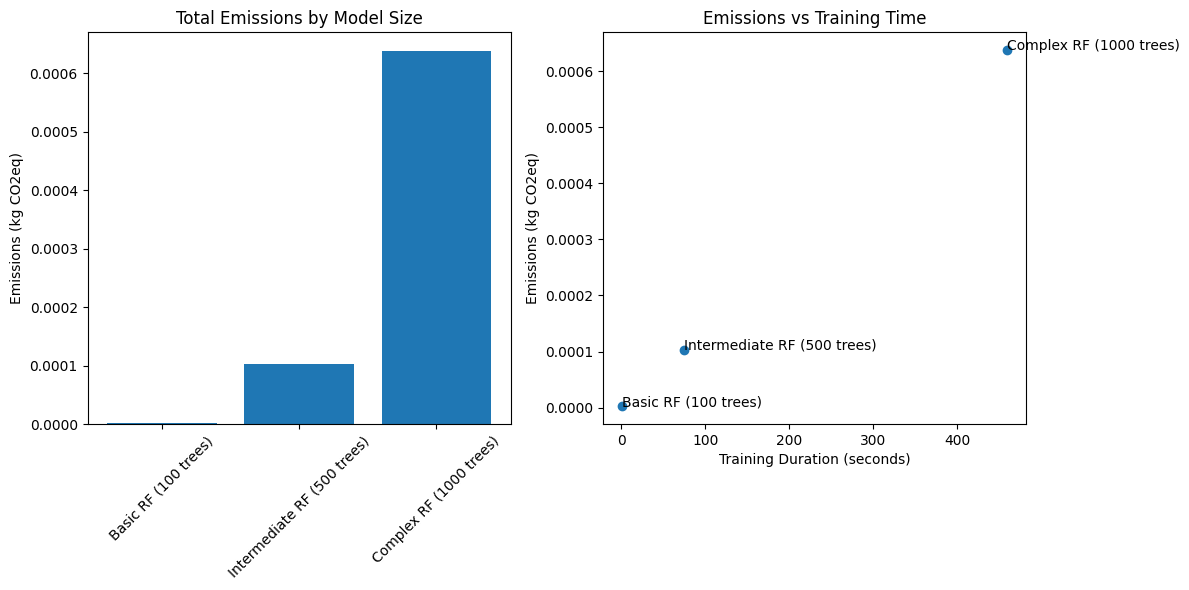

In [6]:
def compare_model_complexities():
    scenarios = [
        {
            'name': 'Basic RF (100 trees)',  # More specific naming
            'n_samples': 10000,
            'n_estimators': 100,
            'max_depth': 5
        },
        {
            'name': 'Intermediate RF (500 trees)',
            'n_samples': 50000,
            'n_estimators': 500,
            'max_depth': 10
        },
        {
            'name': 'Complex RF (1000 trees)',  # Clearer description
            'n_samples': 100000,
            'n_estimators': 1000,
            'max_depth': None
        }
    ]
    
    results = []
    for scenario in scenarios:
        # Generate dataset for this scenario
        X, y = make_classification(
            n_samples=scenario['n_samples'],
            n_features=50,
            n_informative=40,
            random_state=42
        )
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Train and track emissions
        tracker = EmissionsTracker(
            project_name=f"rf_{scenario['name']}",
            output_dir="emissions",
            log_level="warning",
            measure_power_secs=15
        )
        
        tracker.start()
        start_time = time.time()
        
        model = RandomForestClassifier(
            n_estimators=scenario['n_estimators'],
            max_depth=scenario['max_depth'],
            random_state=42
        )
        
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        
        duration = time.time() - start_time
        emissions = tracker.stop()
        
        results.append({
            'scenario': scenario['name'],
            'samples': scenario['n_samples'],
            'n_trees': scenario['n_estimators'],
            'duration': duration,
            'emissions': emissions,
            'accuracy': accuracy,
            'emissions_per_sample': emissions/scenario['n_samples']
        })
    
    return pd.DataFrame(results)

# Run comparison
results_df = compare_model_complexities()

# Display results with better formatting
pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))
print("\nModel Complexity vs Emissions Comparison:")
display(results_df)

# Create visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(results_df['scenario'], results_df['emissions'])
plt.title('Total Emissions by Model Size')
plt.ylabel('Emissions (kg CO2eq)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.scatter(results_df['duration'], results_df['emissions'])
plt.xlabel('Training Duration (seconds)')
plt.ylabel('Emissions (kg CO2eq)')
plt.title('Emissions vs Training Time')

for i, row in results_df.iterrows():
    plt.annotate(row['scenario'], (row['duration'], row['emissions']))

plt.tight_layout()
plt.show()